# Performance Metric Investigation

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from tqdm import tqdm

sns.set(style='darkgrid')
%matplotlib inline

In [2]:
def clean_ohlc(ohlc_df):
    ohlc_df.loc[ohlc_df['Open'] > ohlc_df['High'], 'High'] = ohlc_df['Open']
    ohlc_df.loc[ohlc_df['Open'] < ohlc_df['Low'], 'Low'] = ohlc_df['Open']
    ohlc_df.loc[ohlc_df['Close'] > ohlc_df['High'], 'High'] = ohlc_df['Close']
    ohlc_df.loc[ohlc_df['Close'] < ohlc_df['Low'], 'Low'] = ohlc_df['Close']
    return ohlc_df

def resample_ohlc(ohlc_df, freq='D'):
    resample_df = pd.DataFrame()
    resample_df['Open'] = ohlc_df['Open'].resample(freq).first().copy()
    resample_df['High'] = ohlc_df['High'].resample(freq).max().copy()
    resample_df['Low'] = ohlc_df['Low'].resample(freq).min().copy()
    resample_df['Close'] = ohlc_df['Close'].resample(freq).last().copy()
    resample_df['Volume'] = ohlc_df['Volume'].resample(freq).sum().copy()
    return resample_df

## Load the Data

In [3]:
# Create a blank list of returns
returns_list = []

# Load some bitcoin data
xbt_1d = pd.read_csv('data/XBTUSD_1d.csv', parse_dates=True, index_col=0)

# Add the returns to the list
xbt_1d['returns'] = xbt_1d['Close'].pct_change().dropna()
returns_list.append(xbt_1d['returns'])

# Load in some altcoin data
for altcoin in ['BCH', 'ETH', 'LTC', 'XRP']:
    filepath = 'data/' + altcoin + 'XBT_1d.csv'
    df = pd.read_csv(filepath, parse_dates=True, index_col=0)
    returns = df['Close'].pct_change().dropna()
    returns_list.append(returns)
    
# Load in some ETF data 
path = '/Users/bblandin/Dropbox/Ground-Up Development/Data/Flat Files (Raw)/ETFs'
data_list = os.listdir(path)
for file in data_list:
    file_path = path + '/' + file
    df = pd.read_csv(file_path, parse_dates=True, index_col=0)
    returns = df['Adj Close'].pct_change().dropna()
    returns_list.append(returns)

### Equity Curve Metrics
These are path-dependent and require Monte Carlo simulation to assess accurately

In [4]:
def equity_curve(returns):
    eq = (1 + returns).cumprod(axis=0)
    if len(eq.shape) > 1:
        return pd.DataFrame(eq)
    else:
        return pd.Series(eq)
#     return eq
 
def drawdown(equity_curve):
    _drawdown = equity_curve / equity_curve.cummax() - 1
    return _drawdown
 
def max_drawdown(equity_curve, percent=True):
    abs_drawdown = np.abs(drawdown(equity_curve))
    _max_drawdown = np.max(abs_drawdown)
    if percent == True:
        return _max_drawdown * 100
    else:
        return _max_drawdown
     
def ulcer_index(equity_curve):
    _drawdown = drawdown(equity_curve)
    _ulcer_index = np.sqrt(np.mean(_drawdown**2)) * 100
    return _ulcer_index
 
def twr(equity_curve):
    eq_arr = np.array(equity_curve)
    _twr = eq_arr[-1] / eq_arr[0]
    return _twr
 
def ghpr(equity_curve):
    _twr = twr(equity_curve)
    _ghpr = _twr ** (1 / len(equity_curve)) - 1
    return _ghpr

### Returns Distribution Metrics
These are path-independent and remain the same regardless of which order returns occur in

In [5]:
def sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns)

def sortino_ratio(returns):
    losses = returns[returns <= 0]
    downside_deviation = np.std(losses)
    return np.mean(returns) / downside_deviation

def mean_return(returns):
    return np.mean(returns)

def win_percent(returns):
    wins = returns[returns > 0]
    return len(wins) / len(returns)

def win_loss_ratio(returns):
    wins = returns[returns > 0]
    losses = returns[returns <= 0]
    avg_win = np.mean(wins)
    avg_loss = np.mean(np.abs(losses))
    return avg_win / avg_loss

def profit_factor(returns):
    wins = returns[returns > 0]
    losses = returns[returns <= 0]
    sum_wins = np.sum(wins)
    sum_losses = np.sum(np.abs(losses))
    return sum_wins / sum_losses

def cpc_index(returns):
    _profit_factor = profit_factor(returns)
    _win_percent = win_percent(returns)
    _win_loss_ratio = win_loss_ratio(returns)
    return _profit_factor * _win_percent * _win_loss_ratio

def tail_ratio(returns):
    percentile_5 = np.abs(np.percentile(returns, 5))
    percentile_95 = np.abs(np.percentile(returns, 95))
    return percentile_95 / percentile_5

def common_sense_ratio(returns):
    _common_sense_ratio = profit_factor(returns) * tail_ratio(returns)
    return _common_sense_ratio

def outlier_win_ratio(returns):
    wins = returns[returns > 0]
    mean_win = np.mean(wins)
    outlier_win = np.percentile(returns, 99)
    return outlier_win / mean_win

def outlier_loss_ratio(returns):
    losses = returns[returns <= 0]
    mean_loss = np.mean(np.abs(losses))
    outlier_loss = np.abs(np.percentile(returns, 1))
    return outlier_loss / mean_loss

In [9]:
def ideal_f(returns, time_horizon=250, n_curves=1000, drawdown_limit=20, certainty_level=95):    
    """
    Calculates ideal fraction to stake on an investment with given return distribution 
 
    Args:
        returns: (array-like) distribution that's representative of future returns
        time_horizon: (integer) the number of returns to sample for each curve
        n_curves: (integer) the number of equity curves to generate on each iteration of f
        drawdown_limit: (real) user-specified value for drawdown which must not be exceeded
        certainty_level: (real) the level of confidence that drawdown
            limit will not be exceeded
 
    Returns:
        'f_curve': calculated drawdown and ghpr value at each value of f
        'optimal_f': the ideal fraction of one's account to stake on an investment
        'max_loss': the maximum loss sustained in the provided returns distribution
 
    """
    # print('Calculating ideal f...')
    start = time.time()
     
    f_values = np.linspace(0, 0.99, 200)
    max_loss = np.abs(np.min(returns))
    bounded_f = f_values / max_loss
    f_curve = pd.DataFrame(columns=['ghpr', 'drawdown'])    
    for f in bounded_f:
        # Generate n_curves number of random equity curves
        reordered_returns = np.random.choice(f * returns, size=(time_horizon, n_curves))
        curves = equity_curve(reordered_returns)
        curves_df = pd.DataFrame(curves)        
        # Calculate GHPR and Maximum Drawdown for each equity curve
        curves_drawdown = max_drawdown(curves_df)
        curves_ghpr = ghpr(curves_df) 
        # Calculate drawdown at our certainty level
        drawdown_percentile = np.percentile(curves_drawdown, certainty_level)
        # Calculate median ghpr value
        ghpr_median = np.median(curves_ghpr)
        if drawdown_percentile <= drawdown_limit:
            _ghpr = ghpr_median
        else:
            _ghpr = 0
        f_curve.loc[f, 'ghpr'] = _ghpr * 100
        f_curve.loc[f, 'drawdown'] = drawdown_percentile
    
    try:
        optimal_f = f_curve['ghpr'].astype(float).idxmax()
        max_ghpr = f_curve.loc[optimal_f, 'ghpr']
        return {'f_curve':f_curve, 'optimal_f':optimal_f, 'max_loss':max_loss, 'max_ghpr':max_ghpr}
    
    except(TypeError):
        print('something went wrong')
        return {'f_curve':f_curve, 'optimal_f':0, 'max_loss':0, 'max_ghpr':0} 

In [7]:
def get_performance_metrics(returns):
    
    metric_funcs = [
        sharpe_ratio, sortino_ratio, win_percent, 
        win_loss_ratio, profit_factor, cpc_index,
        tail_ratio, common_sense_ratio, outlier_win_ratio,
        outlier_loss_ratio
    ]
    metric_dict = {
        metric_func.__name__:metric_func(returns) 
        for metric_func in metric_funcs
    }
    ideal_f_results = ideal_f(returns)
    metric_dict['optimal_f'] = ideal_f_results['optimal_f']
    metric_dict['ghpr'] = ideal_f_results['max_ghpr']
    return pd.Series(metric_dict)

In [10]:
# Gather all the metrics we want to track on each run
metric_funcs = [
    sharpe_ratio, sortino_ratio, win_percent, 
    win_loss_ratio, profit_factor, cpc_index,
    tail_ratio, common_sense_ratio, outlier_win_ratio,
    outlier_loss_ratio
]
metric_columns = [
    metric_func.__name__ for metric_func in metric_funcs
]
metric_columns += ['optimal_f', 'ghpr']
metric_df = pd.DataFrame(columns=metric_columns)

# We'll say that our strategies are in the market 25% of the time
exposure = 0.25

for i in tqdm(range(1000)):
    returns = np.random.choice(returns_list)
    sample_size = max(250, int(len(returns) * exposure))
    sample = np.random.choice(returns, sample_size)
    metric_row = get_performance_metrics(sample)
    metric_df = metric_df.append(metric_row, ignore_index=True)
    
metric_df = metric_df[metric_df['ghpr'] > 0]


 15%|█▌        | 152/1000 [06:58<38:55,  2.75s/it]


 30%|███       | 303/1000 [13:50<31:50,  2.74s/it]


 37%|███▋      | 367/1000 [16:48<28:59,  2.75s/it]/Users/bblandin/anaconda3/envs/crypto/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/Users/bblandin/anaconda3/envs/crypto/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Users/bblandin/anaconda3/envs/crypto/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/bblandin/anaconda3/envs/crypto/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
/Users/bblandin/anaconda3/envs/crypto/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/bblandin/anaconda3/envs/crypto/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal
/Users/bblandin/anaconda3/envs/crypto/lib/python

something went wrong



 51%|█████     | 509/1000 [23:08<22:19,  2.73s/it]

something went wrong



 66%|██████▌   | 660/1000 [30:01<15:27,  2.73s/it]


 81%|████████  | 811/1000 [36:37<08:32,  2.71s/it]


 96%|█████████▌| 962/1000 [42:50<01:41,  2.67s/it]


100%|██████████| 1000/1000 [44:40<00:00,  2.68s/it]


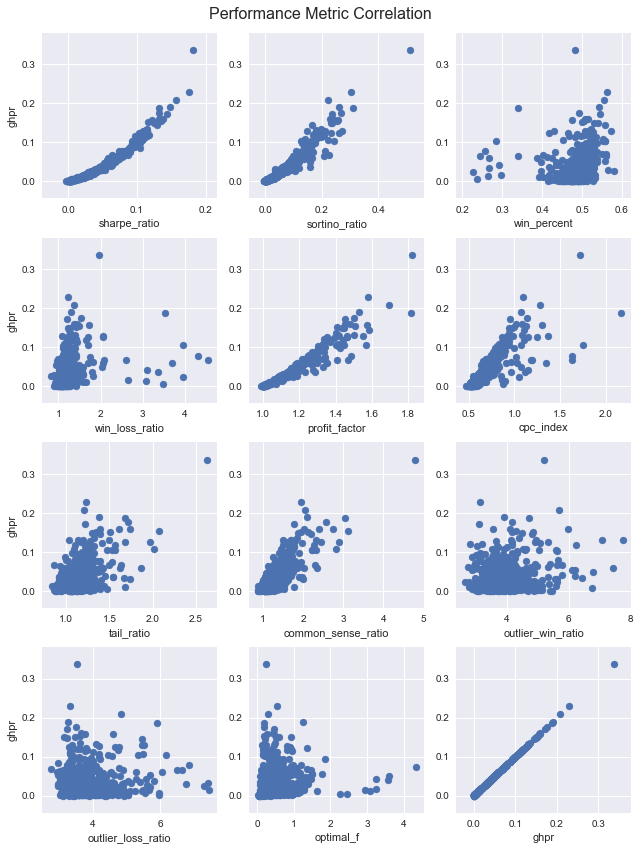

In [29]:
# Plot the results
fig, axes = plt.subplots(4, 3, figsize=(9,12))
metric_df_col_num = 0
for row in range(4):
    axes[row, 0].set_ylabel('ghpr')
    for col in range(3):
        metric_column = metric_df.columns[metric_df_col_num]
        axes[row, col].scatter(metric_df[metric_column], metric_df['ghpr'])
        axes[row, col].set_xlabel(metric_column)
        metric_df_col_num += 1

fig.suptitle('Performance Metric Correlation', size=16)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('Performance Metric Correlation')

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# Single feature is sharpe ratio of returns
X = metric_df['sharpe_ratio'].values.reshape(-1,1)

# Target is median GHPR
y = metric_df['ghpr']

# Split out our training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Use polynomial features to account for non-linear curve
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

# Train our model
model = LinearRegression()
model.fit(X_train, y_train)

# Make some predictions
y_pred = model.predict(X_test)

# How'd we do?
r2 = r2_score(y_test, y_pred)
print('RSQ Achieved: {}%'.format(np.round(r2 * 100, 2)))

RSQ Achieved: 97.16%


In [33]:
X = metric_df.drop(columns=['optimal_f', 'ghpr'])
y = metric_df['ghpr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('RSQ Achieved: {}%'.format(np.round(r2 * 100, 2)))

RSQ Achieved: 96.56%


In [35]:
X = metric_df.drop(columns=['optimal_f', 'ghpr'])
y = metric_df['ghpr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('RSQ Achieved: {}%'.format(np.round(r2 * 100, 2)))

RSQ Achieved: 95.15%
